In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from itertools import product
from survival_models import SurvivalModel
from lifelines import KaplanMeierFitter
import torch
import random
from tqdm import tqdm
import warnings
from collections import defaultdict

# Suppress specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# Requirements:

Need to place the embedding pickle folders in `tts\{DS|L33}_embeddings` directory

The preprocessed pickled files are available to download from: https://cmu.box.com/s/lk5fbdv3lyzgw399gsrfkhl69g9719p7

There is a pickle file for each base embedding LM (e.g., `bert-base-uncased` or `DeepSeek-R1-Distill-Llama-70B`) and time threshold `t`. 
Each Pickle file is dict that has Case Report ID (PMCXXXXXXXX) as key and the value is a dict of `embedding` and `label`. 
`embedding` is vector of encoded textual time series until (and including) time threshold `t`.
`label` is a tuple of (`observed_time`, `event_indicator`) where `event_indicator` is 0 when right-censored and 1 when the patient has died.

# Start Experiments

In [2]:
random_seed = 42
# Set the random seed for reproducibility
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
right_censoring_time = 365*24 # None

In [3]:
embeddings_folder = "L33_embeddings"

In [4]:
model_names = ['bert-base-uncased', 'roberta-base', 'deberta-v3-small', 'ModernBERT-base', 'ModernBERT-large']
model_names += ['DeepSeek-R1-Distill-Llama-70B', 'Llama-3.3-70B-Instruct', 'DeepSeek-R1-Distill-Llama-8B', 'Llama-3.1-8B-Instruct']
survival_models = ['DeepSurv', 'DeepHit'] #, 'RandomSurvivalForest']
task_setup_dict = {"metric": "mean", "max_time": np.inf, "extrapolate_median": True, "random_seed": random_seed}

# Define hyperparameter grids
rf_grid = {
    'n_estimators': [20, 50, 100, 200, 500, 1000],
    'min_samples_split': [2, 10, 20, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20]
}
deep_grid = {
    'num_nodes': [32, 64, 128, 256, 512, 768, 1024, 1200, 1536, 1800, 2048, 3072, 4096],
    'dropout': [0.1, 0.2, 0.4, 0.5]
}

In [5]:
def make_results_table(result_dict):
    columns = pd.MultiIndex.from_product(
        [survival_models + ['Best'], ['concordance_td', 'integrated_brier_score']] #, 'td_auc']]
    )
    data = []

    for model_name in model_names:
        row = []
        model_results = result_dict[model_name]

        # Prepare scalar versions for easy access
        metric_matrix = {
            'concordance_td': {sm: model_results[sm]['concordance_td'] for sm in survival_models},
            'integrated_brier_score': {sm: model_results[sm]['integrated_brier_score'] for sm in survival_models},
            # 'td_auc': {sm: model_results[sm]['td_auc'][-1] for sm in survival_models}  # last element only
        }

        # Fill values for each survival model
        for sm in survival_models:
            row.append(metric_matrix['concordance_td'][sm])
            row.append(metric_matrix['integrated_brier_score'][sm])
            # row.append(metric_matrix['td_auc'][sm])

        # Determine the best model by highest concordance_td
        best_model = max(metric_matrix['concordance_td'], key=lambda sm: metric_matrix['concordance_td'][sm])

        # Populate the Best column using that best_model
        row.append(metric_matrix['concordance_td'][best_model])
        row.append(metric_matrix['integrated_brier_score'][best_model])
        # row.append(metric_matrix['td_auc'][best_model])

        data.append(row)

    return pd.DataFrame(data, index=model_names, columns=columns)


## Time of Interest = 0

In [6]:
time_of_interest = 0

# Define random seeds
random_seeds = [42, 1234, 14, 74, 100]

# Store metrics across seeds
aggregated_results = defaultdict(lambda: defaultdict(list))

for random_seed in random_seeds:
    print(f"Running for seed {random_seed}")
    for model_name in tqdm(model_names):
        data_file = f'tts/{embeddings_folder}/survival_data_embeddings_{model_name}_t{time_of_interest}.pkl'

        with open(data_file, 'rb') as f:
            data_dict = pickle.load(f)

        pmc_ids = list(data_dict.keys())
        random.seed(random_seed)
        test_pmc_ids = set(random.sample(pmc_ids, int(0.2 * len(pmc_ids))))

        train_data = {k: v for k, v in data_dict.items() if k not in test_pmc_ids}
        test_data = {k: data_dict[k] for k in test_pmc_ids}

        X_train = np.array([train_data[cr_id]['embedding'] for cr_id in train_data])
        Y_train = np.array([train_data[cr_id]['label'] for cr_id in train_data])
        Y_train[Y_train[:, 0] >= right_censoring_time] = [right_censoring_time, 0]

        X_test = np.array([test_data[cr_id]['embedding'] for cr_id in test_data])
        Y_test = np.array([test_data[cr_id]['label'] for cr_id in test_data])
        Y_test[Y_test[:, 0] > right_censoring_time] = [right_censoring_time, 0]

        X_train = X_train[Y_train[:, 0] > 0]
        Y_train = Y_train[Y_train[:, 0] > 0]
        X_test = X_test[Y_test[:, 0] > 0]
        Y_test = Y_test[Y_test[:, 0] > 0]

        X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=random_seed)

        rf_grid = {
            'n_estimators': [20, 50, 100],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }
        deep_grid = {
            'num_nodes': [64, 128, 256, 512, 1024, 2048, 4096],
            'dropout': [0.1, 0.5]
        }

        for survival_model in tqdm(survival_models, desc=f"Training Survival Models for {model_name}"):
            best_model = None
            best_val_metric = -np.inf
            best_params = None

            if survival_model == 'RandomSurvivalForest':
                hp_combinations = product(*rf_grid.values())
                hp_keys = list(rf_grid.keys())
            else:
                hp_combinations = product(*deep_grid.values())
                hp_keys = list(deep_grid.keys())

            for hp_vals in hp_combinations:
                hyperparams = dict(zip(hp_keys, hp_vals))
                if survival_model in ['DeepSurv', 'DeepHit']:
                    hyperparams['epochs'] = 2000
                    hyperparams['batch_size'] = 256 if len(X_tr) % 256 != 1 else 250

                model = SurvivalModel(
                    survival_model,
                    hyperparams,
                    extrapolate_median=task_setup_dict["extrapolate_median"],
                    random_seed=random_seed
                )
                model.fit(X_tr, Y_tr)
                val_metrics = model.evaluate(X_val, Y_val)
                val_score = val_metrics['concordance_td']

                if val_score > best_val_metric:
                    best_val_metric = val_score
                    best_model = model
                    best_params = hyperparams

            test_metrics = best_model.evaluate(X_test, Y_test)
            aggregated_results[model_name][survival_model].append(test_metrics)

# Aggregate results
final_results = {}
for model_name in aggregated_results:
    final_results[model_name] = {}
    for surv_model, metrics_list in aggregated_results[model_name].items():
        concordance_vals = [m['concordance_td'] for m in metrics_list]
        ibs_vals = [m['integrated_brier_score'] for m in metrics_list]
        final_results[model_name][surv_model] = {
            'concordance_td_mean': np.mean(concordance_vals),
            'concordance_td_std': np.std(concordance_vals),
            'integrated_brier_score_mean': np.mean(ibs_vals),
            'integrated_brier_score_std': np.std(ibs_vals)
        }

# Convert to DataFrame for visualization
df_summary = []
for model_name in final_results:
    for surv_model in final_results[model_name]:
        row = {
            'embedding_model': model_name,
            'survival_model': surv_model,
            **final_results[model_name][surv_model]
        }
        df_summary.append(row)
df_summary = pd.DataFrame(df_summary)

# Save
with open(f'tts_survival_results_t{time_of_interest}_{embeddings_folder}_5seeds.pkl', 'wb') as f:
    pickle.dump(df_summary, f)

Running for seed 42


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:49<00:00, 84.61s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:50<00:00, 145.04s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [05:02<00:00, 151.31s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [04:16<00:00, 128.24s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:37<00:00, 108.97s/it]
100%|██████████| 9/9 [35:00<00:00, 233.35s/it]


Running for seed 1234


 56%|█████▌    | 5/9 [17:30<14:08, 212.20s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:50<00:00, 145.01s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [05:48<00:00, 174.18s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [04:52<00:00, 146.08s/it]
 89%|████████▉ | 8/9 [33:11<04:42, 282.53s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_worker

Running for seed 14


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [03:50<00:00, 115.47s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [05:15<00:00, 157.58s/it]
 67%|██████▋   | 6/9 [24:03<12:58, 259.50s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [06:10<00:00, 185.32s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [05:14<00:00, 157.37s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [04:14<00:00, 127.19s/it]
100%|██████████| 9/9 [39:53<00:00, 265.94s/it]


Running for seed 74


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [03:13<00:00, 96.85s/it] 
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [05:13<00:00, 156.63s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [05:07<00:00, 153.54s/it]
 78%|███████▊  | 7/9 [27:29<08:51, 265.88s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [04:04<00:00, 122.47s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [04:07<00:00, 123.58s/it]
100%|██████████| 9/9 [35:46<00:00, 238.50s/it]


Running for seed 100


 33%|███▎      | 3/9 [10:13<21:12, 212.02s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
 56%|█████▌    | 5/9 [17:23<14:14, 213.65s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [05:13<00:00, 156.56s/it]
 67%|██████▋   | 6/9 [22:40<12:26, 248.88s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np

In [7]:
df_summary

,embedding_model,survival_model,concordance_td_mean,concordance_td_std,integrated_brier_score_mean,integrated_brier_score_std
0,bert-base-uncased,DeepSurv,0.718371,0.011375,0.103342,0.002699
1,bert-base-uncased,DeepHit,0.714365,0.013223,0.107548,0.002696
2,roberta-base,DeepSurv,0.725569,0.014074,0.103800,0.003026
3,roberta-base,DeepHit,0.728798,0.013548,0.107656,0.004442
4,deberta-v3-small,DeepSurv,0.714219,0.011444,0.104142,0.003263
5,deberta-v3-small,DeepHit,0.698503,0.018419,0.111367,0.004816
6,ModernBERT-base,DeepSurv,0.706734,0.010327,0.104121,0.003120
7,ModernBERT-base,DeepHit,0.694546,0.014762,0.107999,0.003432
8,ModernBERT-large,DeepSurv,0.664769,0.017454,0.110061,0.002527
9,ModernBERT-large,DeepHit,0.639662,0.020147,0.113764,0.003010


In [8]:
# Find best model (based on concordance_td_mean) per embedding model
best_rows = []
for model_name in df_summary['embedding_model'].unique():
    sub_df = df_summary[df_summary['embedding_model'] == model_name]
    best_idx = sub_df['concordance_td_mean'].idxmax()
    best_row = sub_df.loc[best_idx]
    
    # Format the output
    concordance_td = f"{best_row['concordance_td_mean']:.3f} ± {best_row['concordance_td_std']:.3f}"
    ibs = f"{best_row['integrated_brier_score_mean']:.3f} ± {best_row['integrated_brier_score_std']:.3f}"
    
    best_rows.append({
        'embedding_model': model_name,
        'concordance_td': concordance_td,
        'integrated_brier_score': ibs,
        'best_survival_model': best_row['survival_model']
    })

final_table = pd.DataFrame(best_rows)
final_table

,embedding_model,concordance_td,integrated_brier_score,best_survival_model
0,bert-base-uncased,0.718 ± 0.011,0.103 ± 0.003,DeepSurv
1,roberta-base,0.729 ± 0.014,0.108 ± 0.004,DeepHit
2,deberta-v3-small,0.714 ± 0.011,0.104 ± 0.003,DeepSurv
3,ModernBERT-base,0.707 ± 0.010,0.104 ± 0.003,DeepSurv
4,ModernBERT-large,0.665 ± 0.017,0.110 ± 0.003,DeepSurv
5,DeepSeek-R1-Distill-Llama-70B,0.790 ± 0.018,0.098 ± 0.003,DeepHit
6,Llama-3.3-70B-Instruct,0.794 ± 0.024,0.100 ± 0.004,DeepHit
7,DeepSeek-R1-Distill-Llama-8B,0.784 ± 0.019,0.095 ± 0.003,DeepSurv
8,Llama-3.1-8B-Instruct,0.791 ± 0.016,0.100 ± 0.004,DeepHit


Time of interest threshold: 0h
Random Seed: 100
Train: 18226 case reports, 0.92 censoring rate
Test: 4574 case reports, 0.91 censoring rate


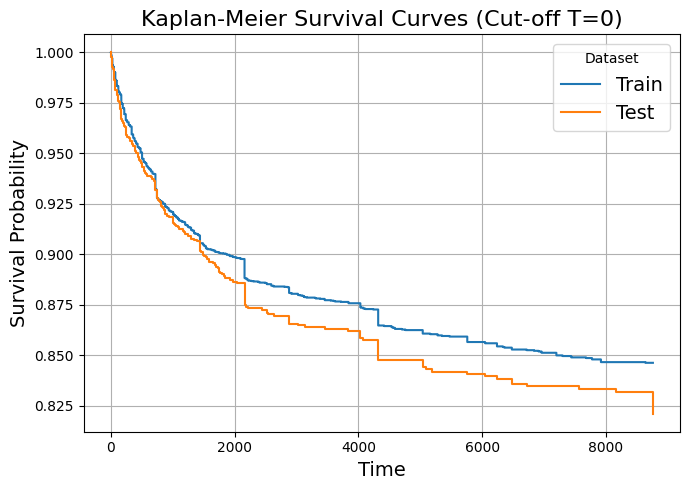

In [9]:
# Plotting Kaplan-Meier survival curves
print(f"Time of interest threshold: {time_of_interest}h")
print("Random Seed:", random_seed)
print(f"Train: {len(Y_train)} case reports, {1-np.mean(Y_train[:, 1]):.2f} censoring rate")
print(f"Test: {len(Y_test)} case reports, {1-np.mean(Y_test[:, 1]):.2f} censoring rate")

# Setup
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 5))

durations, events = Y_train[:, 0], Y_train[:, 1]
kmf.fit(durations, events, label="Train")
kmf.plot(ci_show=False)

durations, events = Y_test[:, 0], Y_test[:, 1]
kmf.fit(durations, events, label="Test")
kmf.plot(ci_show=False)


# Final touches
plt.title(f"Kaplan-Meier Survival Curves (Cut-off T={time_of_interest})", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title="Dataset", fontsize=14)
plt.tight_layout()
plt.grid('minor')
plt.show()


## Time of Interest = 24

In [10]:
time_of_interest = 24

# Define random seeds
random_seeds = [42, 1234, 14, 74, 100]

# Store metrics across seeds
aggregated_results = defaultdict(lambda: defaultdict(list))

for random_seed in random_seeds:
    print(f"Running for seed {random_seed}")
    for model_name in tqdm(model_names):
        data_file = f'tts/{embeddings_folder}/survival_data_embeddings_{model_name}_t{time_of_interest}.pkl'

        with open(data_file, 'rb') as f:
            data_dict = pickle.load(f)

        pmc_ids = list(data_dict.keys())
        random.seed(random_seed)
        test_pmc_ids = set(random.sample(pmc_ids, int(0.2 * len(pmc_ids))))

        train_data = {k: v for k, v in data_dict.items() if k not in test_pmc_ids}
        test_data = {k: data_dict[k] for k in test_pmc_ids}

        X_train = np.array([train_data[cr_id]['embedding'] for cr_id in train_data])
        Y_train = np.array([train_data[cr_id]['label'] for cr_id in train_data])
        Y_train[Y_train[:, 0] >= right_censoring_time] = [right_censoring_time, 0]

        X_test = np.array([test_data[cr_id]['embedding'] for cr_id in test_data])
        Y_test = np.array([test_data[cr_id]['label'] for cr_id in test_data])
        Y_test[Y_test[:, 0] > right_censoring_time] = [right_censoring_time, 0]

        X_train = X_train[Y_train[:, 0] > 0]
        Y_train = Y_train[Y_train[:, 0] > 0]
        X_test = X_test[Y_test[:, 0] > 0]
        Y_test = Y_test[Y_test[:, 0] > 0]

        X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=random_seed)

        rf_grid = {
            'n_estimators': [20, 50, 100],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }
        deep_grid = {
            'num_nodes': [64, 128, 256, 512, 1024, 2048, 4096],
            'dropout': [0.1, 0.5]
        }

        for survival_model in tqdm(survival_models, desc=f"Training Survival Models for {model_name}"):
            best_model = None
            best_val_metric = -np.inf
            best_params = None

            if survival_model == 'RandomSurvivalForest':
                hp_combinations = product(*rf_grid.values())
                hp_keys = list(rf_grid.keys())
            else:
                hp_combinations = product(*deep_grid.values())
                hp_keys = list(deep_grid.keys())

            for hp_vals in hp_combinations:
                hyperparams = dict(zip(hp_keys, hp_vals))
                if survival_model in ['DeepSurv', 'DeepHit']:
                    hyperparams['epochs'] = 2000
                    hyperparams['batch_size'] = 256 if len(X_tr) % 256 != 1 else 250

                model = SurvivalModel(
                    survival_model,
                    hyperparams,
                    extrapolate_median=task_setup_dict["extrapolate_median"],
                    random_seed=random_seed
                )
                model.fit(X_tr, Y_tr)
                val_metrics = model.evaluate(X_val, Y_val)
                val_score = val_metrics['concordance_td']

                if val_score > best_val_metric:
                    best_val_metric = val_score
                    best_model = model
                    best_params = hyperparams

            test_metrics = best_model.evaluate(X_test, Y_test)
            aggregated_results[model_name][survival_model].append(test_metrics)

# Aggregate results
final_results = {}
for model_name in aggregated_results:
    final_results[model_name] = {}
    for surv_model, metrics_list in aggregated_results[model_name].items():
        concordance_vals = [m['concordance_td'] for m in metrics_list]
        ibs_vals = [m['integrated_brier_score'] for m in metrics_list]
        final_results[model_name][surv_model] = {
            'concordance_td_mean': np.mean(concordance_vals),
            'concordance_td_std': np.std(concordance_vals),
            'integrated_brier_score_mean': np.mean(ibs_vals),
            'integrated_brier_score_std': np.std(ibs_vals)
        }

# Convert to DataFrame for visualization
df_summary = []
for model_name in final_results:
    for surv_model in final_results[model_name]:
        row = {
            'embedding_model': model_name,
            'survival_model': surv_model,
            **final_results[model_name][surv_model]
        }
        df_summary.append(row)
df_summary = pd.DataFrame(df_summary)

# Save
with open(f'tts_survival_results_t{time_of_interest}_{embeddings_folder}_5seeds.pkl', 'wb') as f:
    pickle.dump(df_summary, f)

Running for seed 42


 33%|███▎      | 3/9 [10:39<21:58, 219.79s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [03:32<00:00, 106.40s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [05:09<00:00, 154.57s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:57<00:00, 148.57s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [04:08<00:00, 124.41s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:57<00:00, 118.65s/it]
100%|██████████| 9/9 [36:29<00:00, 243.28s/it]


Running for seed 1234


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [03:04<00:00, 92.37s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [06:42<00:00, 201.26s/it]
 67%|██████▋   | 6/9 [23:08<13:30, 270.15s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [05:42<00:00, 171.20s/it]
 78%|███████▊  | 7/9 [28:55<09:50, 295.35s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [04:20<00:00, 130.31s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:58<00:00, 119.29s

Running for seed 14


 56%|█████▌    | 5/9 [18:03<13:50, 207.54s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:17<00:00, 128.86s/it]
 67%|██████▋   | 6/9 [22:25<11:18, 226.02s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [05:45<00:00, 172.52s/it]
 78%|███████▊  | 7/9 [28:14<08:52, 266.28s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for DeepSe

Running for seed 74


 44%|████▍     | 4/9 [12:47<16:30, 198.02s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [03:07<00:00, 93.92s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:52<00:00, 146.08s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:41<00:00, 140.82s/it]
 78%|███████▊  | 7/9 [25:47<08:18, 249.16s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_worke

Running for seed 100


 56%|█████▌    | 5/9 [15:36<12:40, 190.01s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:38<00:00, 139.04s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [05:06<00:00, 153.11s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [04:18<00:00, 129.11s/it]
 89%|████████▉ | 8/9 [29:49<04:13, 253.75s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:26<00:00, 103.40s/it]
100%|██████████| 9/9 [33:18<00:00, 222.04s/it]


In [11]:
df_summary

,embedding_model,survival_model,concordance_td_mean,concordance_td_std,integrated_brier_score_mean,integrated_brier_score_std
0,bert-base-uncased,DeepSurv,0.729892,0.009373,0.100677,0.002527
1,bert-base-uncased,DeepHit,0.728185,0.017482,0.101909,0.002986
2,roberta-base,DeepSurv,0.726930,0.014445,0.100015,0.002243
3,roberta-base,DeepHit,0.726800,0.015239,0.104538,0.002507
4,deberta-v3-small,DeepSurv,0.723246,0.010170,0.101236,0.002476
5,deberta-v3-small,DeepHit,0.709653,0.015957,0.106453,0.001764
6,ModernBERT-base,DeepSurv,0.705573,0.011881,0.102003,0.004087
7,ModernBERT-base,DeepHit,0.704854,0.008659,0.103638,0.003063
8,ModernBERT-large,DeepSurv,0.672431,0.017056,0.106117,0.002210
9,ModernBERT-large,DeepHit,0.652191,0.022354,0.109423,0.003924


In [12]:
# Find best model (based on concordance_td_mean) per embedding model
best_rows = []
for model_name in df_summary['embedding_model'].unique():
    sub_df = df_summary[df_summary['embedding_model'] == model_name]
    best_idx = sub_df['concordance_td_mean'].idxmax()
    best_row = sub_df.loc[best_idx]
    
    # Format the output
    concordance_td = f"{best_row['concordance_td_mean']:.3f} ± {best_row['concordance_td_std']:.3f}"
    ibs = f"{best_row['integrated_brier_score_mean']:.3f} ± {best_row['integrated_brier_score_std']:.3f}"
    
    best_rows.append({
        'embedding_model': model_name,
        'concordance_td': concordance_td,
        'integrated_brier_score': ibs,
        'best_survival_model': best_row['survival_model']
    })

final_table = pd.DataFrame(best_rows)
final_table

,embedding_model,concordance_td,integrated_brier_score,best_survival_model
0,bert-base-uncased,0.730 ± 0.009,0.101 ± 0.003,DeepSurv
1,roberta-base,0.727 ± 0.014,0.100 ± 0.002,DeepSurv
2,deberta-v3-small,0.723 ± 0.010,0.101 ± 0.002,DeepSurv
3,ModernBERT-base,0.706 ± 0.012,0.102 ± 0.004,DeepSurv
4,ModernBERT-large,0.672 ± 0.017,0.106 ± 0.002,DeepSurv
5,DeepSeek-R1-Distill-Llama-70B,0.798 ± 0.016,0.094 ± 0.002,DeepHit
6,Llama-3.3-70B-Instruct,0.798 ± 0.017,0.096 ± 0.001,DeepHit
7,DeepSeek-R1-Distill-Llama-8B,0.785 ± 0.017,0.092 ± 0.003,DeepSurv
8,Llama-3.1-8B-Instruct,0.795 ± 0.020,0.096 ± 0.003,DeepHit


Time of interest threshold: 24h
Random Seed: 100
Train: 16753 case reports, 0.92 censoring rate
Test: 4200 case reports, 0.91 censoring rate


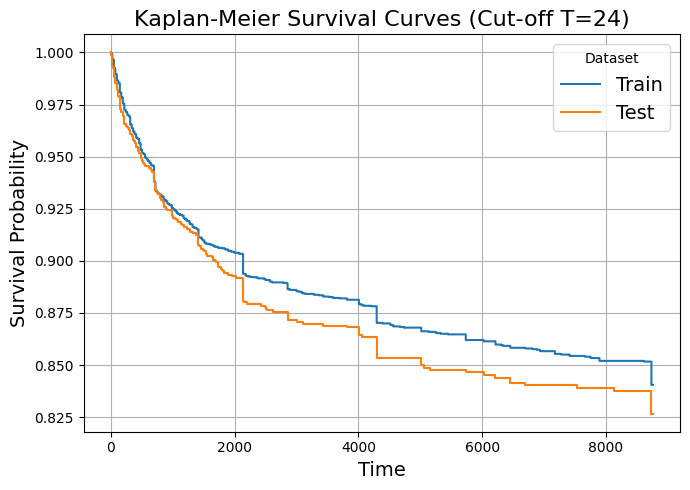

In [13]:
# Plotting Kaplan-Meier survival curves
print(f"Time of interest threshold: {time_of_interest}h")
print("Random Seed:", random_seed)
print(f"Train: {len(Y_train)} case reports, {1-np.mean(Y_train[:, 1]):.2f} censoring rate")
print(f"Test: {len(Y_test)} case reports, {1-np.mean(Y_test[:, 1]):.2f} censoring rate")

# Setup
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 5))

durations, events = Y_train[:, 0], Y_train[:, 1]
kmf.fit(durations, events, label="Train")
kmf.plot(ci_show=False)

durations, events = Y_test[:, 0], Y_test[:, 1]
kmf.fit(durations, events, label="Test")
kmf.plot(ci_show=False)


# Final touches
plt.title(f"Kaplan-Meier Survival Curves (Cut-off T={time_of_interest})", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title="Dataset", fontsize=14)
plt.tight_layout()
plt.grid('minor')
plt.show()


## Time of Interest = 168

In [14]:
time_of_interest = 168

# Define random seeds
random_seeds = [42, 1234, 14, 74, 100]

# Store metrics across seeds
aggregated_results = defaultdict(lambda: defaultdict(list))

for random_seed in random_seeds:
    print(f"Running for seed {random_seed}")
    for model_name in tqdm(model_names):
        data_file = f'tts/{embeddings_folder}/survival_data_embeddings_{model_name}_t{time_of_interest}.pkl'

        with open(data_file, 'rb') as f:
            data_dict = pickle.load(f)

        pmc_ids = list(data_dict.keys())
        random.seed(random_seed)
        test_pmc_ids = set(random.sample(pmc_ids, int(0.2 * len(pmc_ids))))

        train_data = {k: v for k, v in data_dict.items() if k not in test_pmc_ids}
        test_data = {k: data_dict[k] for k in test_pmc_ids}

        X_train = np.array([train_data[cr_id]['embedding'] for cr_id in train_data])
        Y_train = np.array([train_data[cr_id]['label'] for cr_id in train_data])
        Y_train[Y_train[:, 0] >= right_censoring_time] = [right_censoring_time, 0]

        X_test = np.array([test_data[cr_id]['embedding'] for cr_id in test_data])
        Y_test = np.array([test_data[cr_id]['label'] for cr_id in test_data])
        Y_test[Y_test[:, 0] > right_censoring_time] = [right_censoring_time, 0]

        X_train = X_train[Y_train[:, 0] > 0]
        Y_train = Y_train[Y_train[:, 0] > 0]
        X_test = X_test[Y_test[:, 0] > 0]
        Y_test = Y_test[Y_test[:, 0] > 0]

        X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=random_seed)

        rf_grid = {
            'n_estimators': [20, 50, 100],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }
        deep_grid = {
            'num_nodes': [64, 128, 256, 512, 1024, 2048, 4096],
            'dropout': [0.1, 0.5]
        }

        for survival_model in tqdm(survival_models, desc=f"Training Survival Models for {model_name}"):
            best_model = None
            best_val_metric = -np.inf
            best_params = None

            if survival_model == 'RandomSurvivalForest':
                hp_combinations = product(*rf_grid.values())
                hp_keys = list(rf_grid.keys())
            else:
                hp_combinations = product(*deep_grid.values())
                hp_keys = list(deep_grid.keys())

            for hp_vals in hp_combinations:
                hyperparams = dict(zip(hp_keys, hp_vals))
                if survival_model in ['DeepSurv', 'DeepHit']:
                    hyperparams['epochs'] = 2000
                    hyperparams['batch_size'] = 256 if len(X_tr) % 256 != 1 else 250

                model = SurvivalModel(
                    survival_model,
                    hyperparams,
                    extrapolate_median=task_setup_dict["extrapolate_median"],
                    random_seed=random_seed
                )
                model.fit(X_tr, Y_tr)
                val_metrics = model.evaluate(X_val, Y_val)
                val_score = val_metrics['concordance_td']

                if val_score > best_val_metric:
                    best_val_metric = val_score
                    best_model = model
                    best_params = hyperparams

            test_metrics = best_model.evaluate(X_test, Y_test)
            aggregated_results[model_name][survival_model].append(test_metrics)

# Aggregate results
final_results = {}
for model_name in aggregated_results:
    final_results[model_name] = {}
    for surv_model, metrics_list in aggregated_results[model_name].items():
        concordance_vals = [m['concordance_td'] for m in metrics_list]
        ibs_vals = [m['integrated_brier_score'] for m in metrics_list]
        final_results[model_name][surv_model] = {
            'concordance_td_mean': np.mean(concordance_vals),
            'concordance_td_std': np.std(concordance_vals),
            'integrated_brier_score_mean': np.mean(ibs_vals),
            'integrated_brier_score_std': np.std(ibs_vals)
        }

# Convert to DataFrame for visualization
df_summary = []
for model_name in final_results:
    for surv_model in final_results[model_name]:
        row = {
            'embedding_model': model_name,
            'survival_model': surv_model,
            **final_results[model_name][surv_model]
        }
        df_summary.append(row)
df_summary = pd.DataFrame(df_summary)

# Save
with open(f'tts_survival_results_t{time_of_interest}_{embeddings_folder}_5seeds.pkl', 'wb') as f:
    pickle.dump(df_summary, f)

Running for seed 42


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [01:59<00:00, 59.59s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:20<00:00, 100.40s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:40<00:00, 140.16s/it]
 78%|███████▊  | 7/9 [21:27<06:59, 209.97s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [02:21<00:00, 70.79s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [02:51<00:00, 85.58s/it]
100%|██████████| 9/9 [26:45<00:00, 178.43s/it]


Running for seed 1234


 33%|███▎      | 3/9 [07:43<15:49, 158.29s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
 44%|████▍     | 4/9 [10:33<13:33, 162.73s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow e

Running for seed 14


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:22<00:00, 71.09s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:03<00:00, 121.83s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:26<00:00, 133.00s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [02:55<00:00, 87.67s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:10<00:00, 95.23s/it] 
100%|██████████| 9/9 [27:24<00:00, 182.73s/it]


Running for seed 74


 44%|████▍     | 4/9 [10:31<13:28, 161.75s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:37<00:00, 78.98s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:42<00:00, 111.28s/it]
 67%|██████▋   | 6/9 [17:06<09:15, 185.18s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: Runtim

Running for seed 100


 44%|████▍     | 4/9 [10:14<13:19, 159.92s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
 56%|█████▌    | 5/9 [12:54<10:40, 160.03s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:25<00:0

In [15]:
df_summary

,embedding_model,survival_model,concordance_td_mean,concordance_td_std,integrated_brier_score_mean,integrated_brier_score_std
0,bert-base-uncased,DeepSurv,0.733069,0.018986,0.090362,0.002333
1,bert-base-uncased,DeepHit,0.723613,0.014480,0.092497,0.001626
2,roberta-base,DeepSurv,0.741414,0.017359,0.089262,0.002355
3,roberta-base,DeepHit,0.743104,0.018063,0.090385,0.002092
4,deberta-v3-small,DeepSurv,0.744592,0.019004,0.088761,0.003050
5,deberta-v3-small,DeepHit,0.724442,0.018302,0.094107,0.001846
6,ModernBERT-base,DeepSurv,0.729029,0.019291,0.092466,0.004581
7,ModernBERT-base,DeepHit,0.726872,0.010468,0.092490,0.001770
8,ModernBERT-large,DeepSurv,0.661523,0.031025,0.096169,0.003107
9,ModernBERT-large,DeepHit,0.647767,0.025566,0.096693,0.002663


In [16]:
# Find best model (based on concordance_td_mean) per embedding model
best_rows = []
for model_name in df_summary['embedding_model'].unique():
    sub_df = df_summary[df_summary['embedding_model'] == model_name]
    best_idx = sub_df['concordance_td_mean'].idxmax()
    best_row = sub_df.loc[best_idx]
    
    # Format the output
    concordance_td = f"{best_row['concordance_td_mean']:.3f} ± {best_row['concordance_td_std']:.3f}"
    ibs = f"{best_row['integrated_brier_score_mean']:.3f} ± {best_row['integrated_brier_score_std']:.3f}"
    
    best_rows.append({
        'embedding_model': model_name,
        'concordance_td': concordance_td,
        'integrated_brier_score': ibs,
        'best_survival_model': best_row['survival_model']
    })

final_table = pd.DataFrame(best_rows)
final_table

,embedding_model,concordance_td,integrated_brier_score,best_survival_model
0,bert-base-uncased,0.733 ± 0.019,0.090 ± 0.002,DeepSurv
1,roberta-base,0.743 ± 0.018,0.090 ± 0.002,DeepHit
2,deberta-v3-small,0.745 ± 0.019,0.089 ± 0.003,DeepSurv
3,ModernBERT-base,0.729 ± 0.019,0.092 ± 0.005,DeepSurv
4,ModernBERT-large,0.662 ± 0.031,0.096 ± 0.003,DeepSurv
5,DeepSeek-R1-Distill-Llama-70B,0.796 ± 0.015,0.086 ± 0.003,DeepHit
6,Llama-3.3-70B-Instruct,0.800 ± 0.018,0.085 ± 0.002,DeepHit
7,DeepSeek-R1-Distill-Llama-8B,0.790 ± 0.012,0.084 ± 0.003,DeepSurv
8,Llama-3.1-8B-Instruct,0.796 ± 0.014,0.083 ± 0.002,DeepSurv


Time of interest threshold: 168h
Random Seed: 100
Train: 13296 case reports, 0.92 censoring rate
Test: 3335 case reports, 0.92 censoring rate


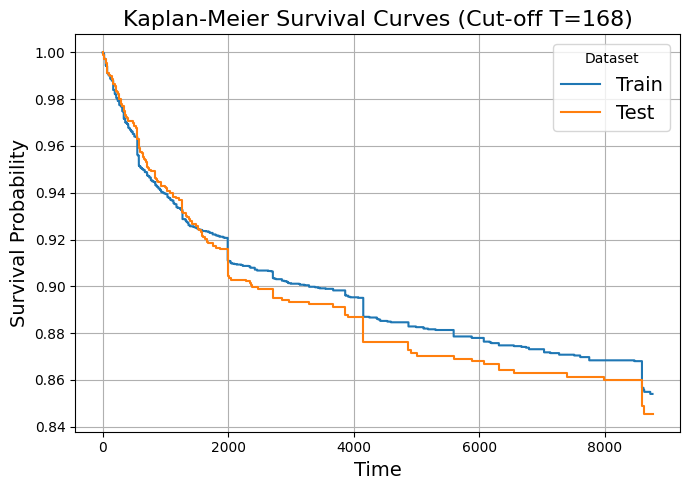

In [17]:
# Plotting Kaplan-Meier survival curves
print(f"Time of interest threshold: {time_of_interest}h")
print("Random Seed:", random_seed)
print(f"Train: {len(Y_train)} case reports, {1-np.mean(Y_train[:, 1]):.2f} censoring rate")
print(f"Test: {len(Y_test)} case reports, {1-np.mean(Y_test[:, 1]):.2f} censoring rate")

# Setup
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 5))

durations, events = Y_train[:, 0], Y_train[:, 1]
kmf.fit(durations, events, label="Train")
kmf.plot(ci_show=False)

durations, events = Y_test[:, 0], Y_test[:, 1]
kmf.fit(durations, events, label="Test")
kmf.plot(ci_show=False)


# Final touches
plt.title(f"Kaplan-Meier Survival Curves (Cut-off T={time_of_interest})", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title="Dataset", fontsize=14)
plt.tight_layout()
plt.grid('minor')
plt.show()
